# Customer Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle

# Data Preprocessing

In [2]:
df=pd.read_excel('customer_churn_large_dataset.xlsx',index_col=0) # loading dataset to pandas dataframe
                                                                # index_col=0 sets the customer id column as the index

In [3]:
df.shape  # shape of the dataframe (rows, columns)

(100000, 8)

In [4]:
df.head()  # looking at the dataset

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,,
1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
2,Customer_2,62,Female,New York,1,48.76,172,0
3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
4,Customer_4,36,Female,Miami,3,97.94,297,1
5,Customer_5,46,Female,Miami,19,58.14,266,0


In [5]:
df.info() # looking at datatypes of each column

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 1 to 100000
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        100000 non-null  object 
 1   Age                         100000 non-null  int64  
 2   Gender                      100000 non-null  object 
 3   Location                    100000 non-null  object 
 4   Subscription_Length_Months  100000 non-null  int64  
 5   Monthly_Bill                100000 non-null  float64
 6   Total_Usage_GB              100000 non-null  int64  
 7   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 6.9+ MB


In [6]:
df.isnull().sum() # checking for null values 

Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In [7]:
df.isna().sum() # checking for missing values

Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In [8]:
df.duplicated().sum() # checking duplicate rows

0

In [9]:
df.describe()  # basic statistics on numeric columns

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,44.027020,12.490100,65.053197,274.393650,0.497790
std,15.280283,6.926461,20.230696,130.463063,0.499998
min,18.000000,1.000000,30.000000,50.000000,0.000000
25%,31.000000,6.000000,47.540000,161.000000,0.000000
50%,44.000000,12.000000,65.010000,274.000000,0.000000
75%,57.000000,19.000000,82.640000,387.000000,1.000000
max,70.000000,24.000000,100.000000,500.000000,1.000000


### Comments 
##### 1. We have total 8 columns and 100000 rows.
##### 2. The dataset has three categorical columns and five numerical columns.
##### 3. The column 'Churn' is our target variable. It contains entries 0 and 1. {0: not churned , 1: churned}
##### 4. The name column is also a unique identifier and will not help us in our ML model so I'll drop it.
##### 5. There are no null or missing values in the dataset.
##### 6. There are no duplicate rows in the dataset.
##### 7. I set the customer id column as the index as it is a unique  identifier and we dont need it much.
##### 8. The problem is a binary classification problem.

In [10]:
# dropping the name column

df.drop('Name',axis=1,inplace=True)  # inplace=True reflects the changes in the dataframe as well

# Exploratory Data Analysis

### Univariate Analysis

In [11]:
warnings.filterwarnings("ignore") # warnings are not shown

Churn
0    50221
1    49779
Name: count, dtype: int64


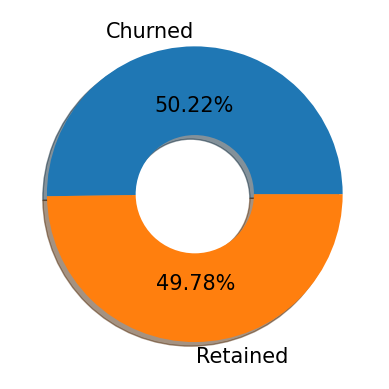

In [12]:
# visualising percentage of churned and retained customers

# counts the number of churned and retained customers
churn_count=df['Churn'].value_counts()  

# plotting using  donut chart (variant of pie chart)
plt.pie(churn_count,labels=['Churned','Retained'],autopct="%0.02f%%",shadow=True,wedgeprops={"width":0.6},textprops={"fontsize":15});

# printing values
print(churn_count);

### Comments
##### 1. The target variable is balanced. Almost same number of churned and retained customers.
##### 2. Imbalanced data sets require techniques like over sampling and under sampling. We won't need them here.

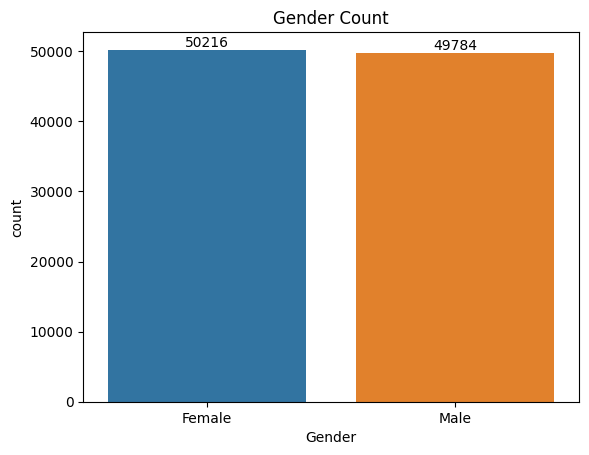

In [13]:
# visualisation of number of males and females

# counts the number of male and female customers
gender_count = df['Gender'].value_counts() 

# plotting using  bar chart
ax=sns.barplot(x=gender_count.index,y=gender_count);

ax.bar_label(ax.containers[0]);  # writes the count on top of bars

# setting title of the plot
plt.title("Gender Count");

### Comments
##### 1. Almost equal number of male and female customers. 

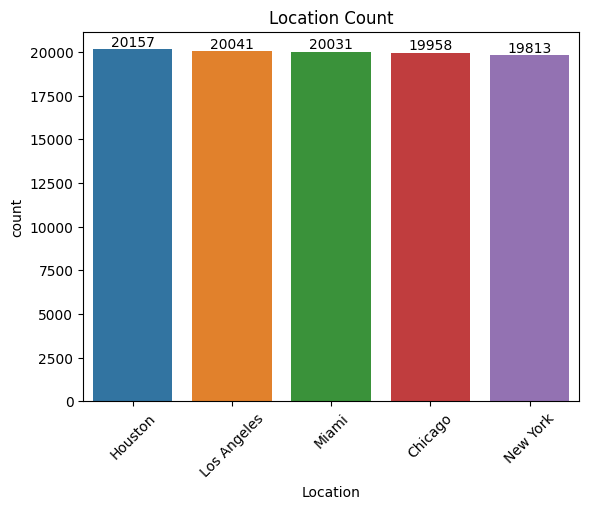

In [14]:
# visualising number of customers from each location

# gives number of customers from each location
loc_count = df['Location'].value_counts()

#plotting using bar chart
ax=sns.barplot(x=loc_count.index,y=loc_count);

ax.bar_label(ax.containers[0])  # writes the count on top of bars

# rotating x ticks for better readbiility
plt.xticks(rotation=45);

# setting title of the plot
plt.title("Location Count");

### Comments
##### 1. There are five locations where customers are located.
##### 2. Almost equal number of customers from each location 

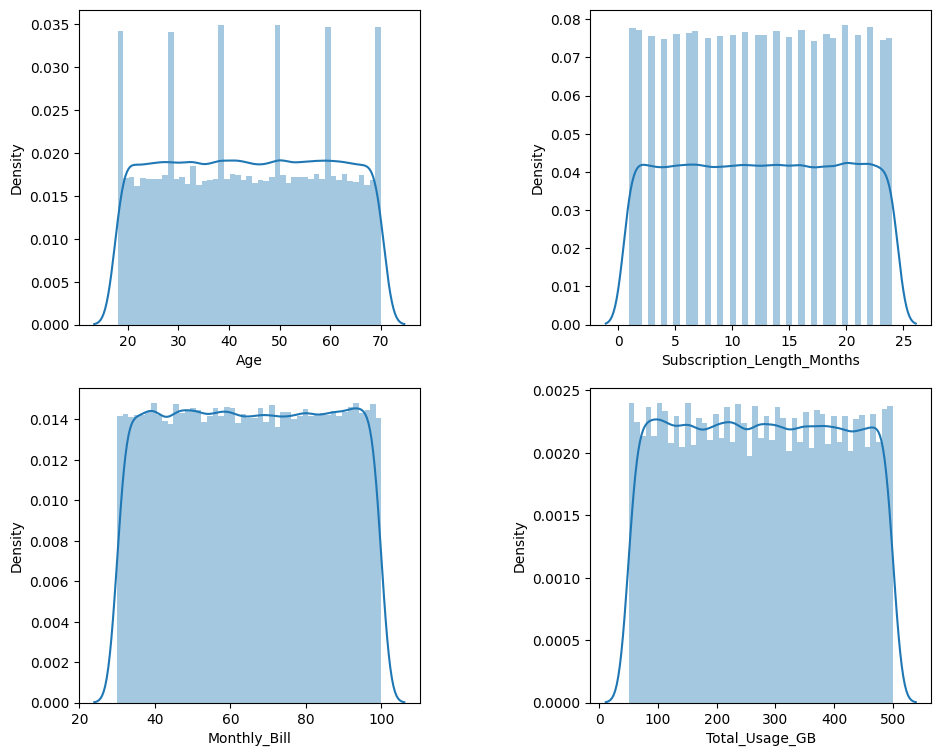

In [15]:
# distributions of numeric columns

plt.figure(figsize=(11,9)) # defining figure size
plt.subplots_adjust(wspace=0.5) # giving space between plots

# adding first subplot
plt.subplot(2,2,1)
sns.distplot(df['Age'])

# adding second subplot
plt.subplot(2,2,2)
sns.distplot(df['Subscription_Length_Months'])

# adding third subplot
plt.subplot(2,2,3)
sns.distplot(df['Monthly_Bill'])

# adding fourth subplot
plt.subplot(2,2,4)
sns.distplot(df['Total_Usage_GB']);



### Comments 
##### 1. All the numerical variables have uniform distributions.
##### 2. There are many unique values in all the columns but they have almost equal frequency of occurence.
##### 3. We will try to get more information from these numeric columns later .

### Bivariate Analysis

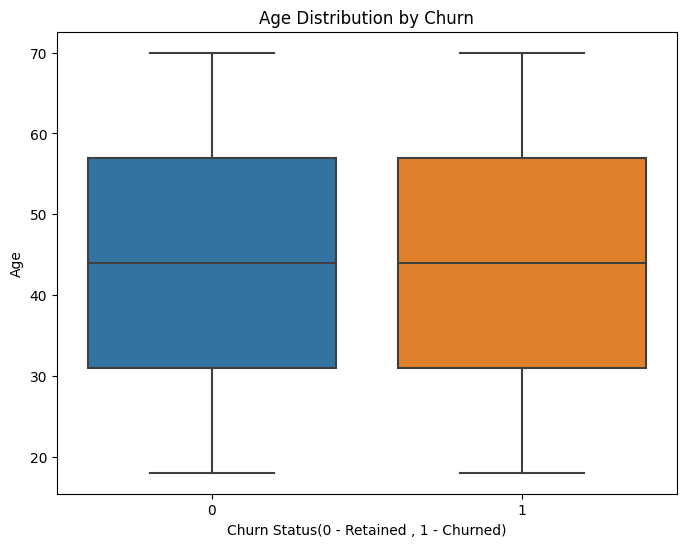

In [16]:
# checking relation between Age and Churn rate

# defining figure size
plt.figure(figsize=(8, 6))

# making boxplots for age distribution specified by churn
sns.boxplot(x='Churn', y='Age', data=df[['Age','Churn']])

# setting title of the plot
plt.title('Age Distribution by Churn')

# setting x and y axis labels
plt.xlabel('Churn Status(0 - Retained , 1 - Churned)')
plt.ylabel('Age');


### Comments
##### 1. Almost similar box plots for both churned and retained customers.
##### 2. For now our analysis tells that age does not significantly affects churn. 
##### 3. I will later perform a t-test to compare the means of Age between the two groups.

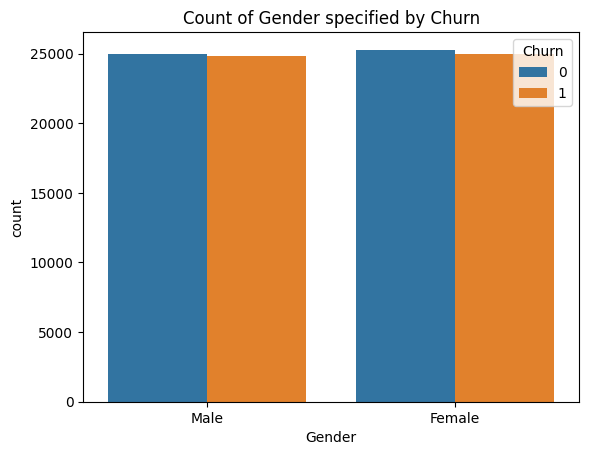

In [17]:
# checking how gender affects churn

# plotting countplot
sns.countplot(data=df,x='Gender',hue='Churn');

# setting title of the plot
plt.title("Count of Gender specified by Churn");

### Comments
##### 1. Number of churned customers are almost equal to retained customers in both genders.
##### 2. Looks like Gender does not affect the churn rate too much.
##### 3. I will later investigate whether 'Gender' has an impact on 'Churn' using a Contingency Table and Chi-Squared test.

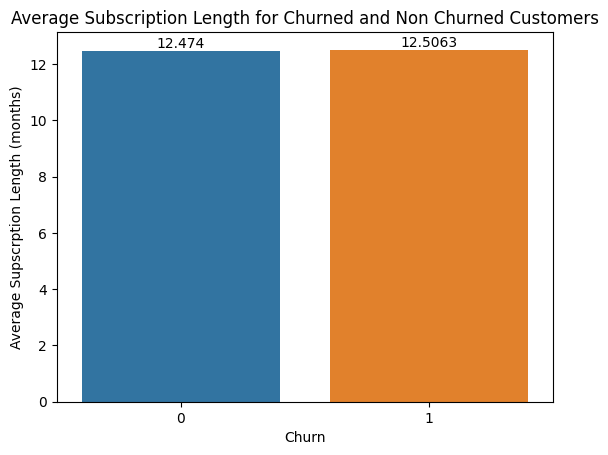

In [18]:
# checking how 'Subscription_Length_Months' relates to 'Churn' by comparing the average Subscription Length

# Calculating the average subscription length for Churned and Retained customers
avg_subscription= df.groupby('Churn')['Subscription_Length_Months'].mean()

# plotting the average length
ax=sns.barplot(x=avg_subscription.index,y=avg_subscription);

ax.bar_label(ax.containers[0]);  # writes the count on top of bars

# setting y axis label
plt.ylabel('Average Supscrption Length (months)');

# setting title of the plot
plt.title("Average Subscription Length for Churned and Non Churned Customers");

### Comments
##### 1. The average Subscription Length in months is almost equal for churned and retained customers.
##### 2. Subscription length doesn't seem to affect churn too much.

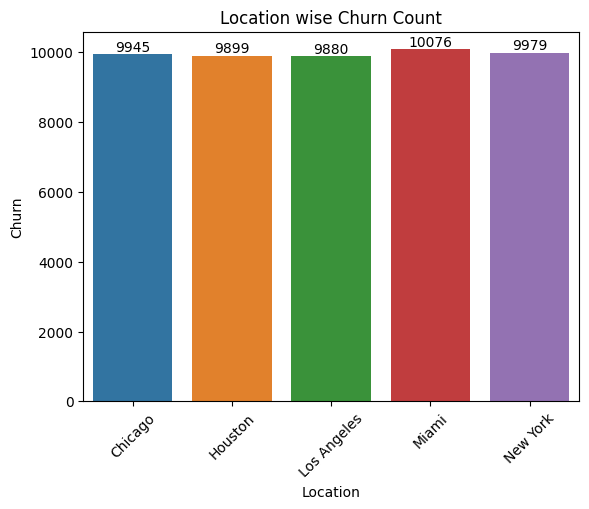

In [19]:
# checking customer churn for different locations

# number of churned customers for each  location
location_churn=df.groupby('Location')['Churn'].sum()

#plotting using bar chart
ax=sns.barplot(x=location_churn.index,y=location_churn);

ax.bar_label(ax.containers[0])  # writes the count on top of bars

# rotating xticks for better readability
plt.xticks(rotation=45);

# setting title of the plot
plt.title("Location wise Churn Count");

### Comments
##### 1. The number of churned customers is almost equal for all locations.

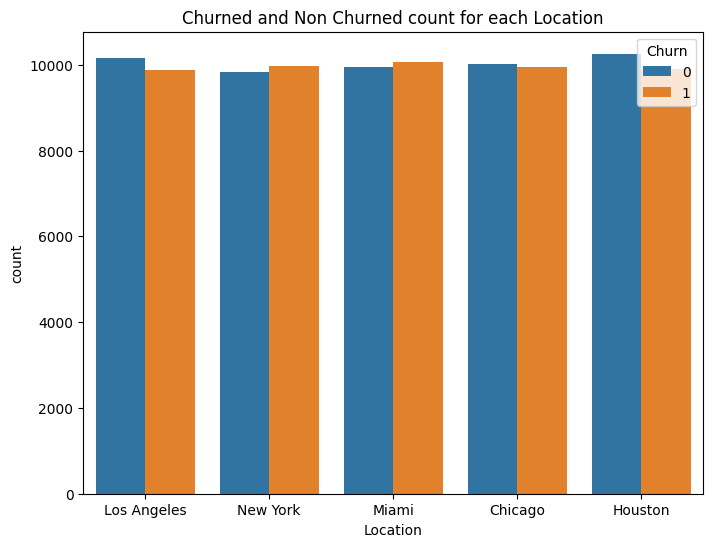

In [20]:
# customer churn specified by location

# defining figure size
plt.figure(figsize=(8, 6))

# plotting count plot
sns.countplot(data=df,x='Location',hue='Churn');

# setting title of the plot
plt.title("Churned and Non Churned count for each Location");

### Comments
##### 1. The number of churned and non churned customers is almost equal for each location.
##### 2. This suggests that loctaion does not significantly affects customer churn.
##### 3. I will further use some statistical methods to confirm this.

### Statistical approach
##### 1. The above EDA does not provide much information about the key features that might affect churn.
##### 2. Now I will use some statistical methods like t-test, chi-squared test, contingency tables etc. to see relationship between churn and other features.

In [21]:
# Using a t-test to check the relationship between age and customer churn

age_churned = df[df['Churn'] == 1]['Age']
age_non_churned = df[df['Churn'] == 0]['Age']

# Perform a t-test to compare the means of 'Age' between the two groups
t_statistic, p_value = stats.ttest_ind(age_churned, age_non_churned)

# Define the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than alpha to determine significance
if p_value < alpha:
    print('\033[1m'+"There is a significant difference in 'Age' between churned and non-churned groups.") # '\033[1m' is used to print in bold text
else:
    print( '\033[1m' +"There is no significant difference in 'Age' between churned and non-churned groups.")

There is no significant difference in 'Age' between churned and non-churned groups.


In [22]:
# Create a contingency table for 'Gender' and 'Churn'
contingency_table = pd.crosstab(df['Gender'], df['Churn'])

# Perform a chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Check if the p-value is less than alpha (commonly 0.05) to determine significance
alpha = 0.05
if p < alpha:
    print('\033[1m'+"Gender has a significant impact on Churn.")  # '\033[1m' is used to print in bold text
else:
    print('\033[1m'+"Gender does not have a significant impact on Churn.")

Gender does not have a significant impact on Churn.


In [23]:
# Calculate the Pearson correlation coefficient and its p-value
corr_coeff, p_value = pearsonr(df['Monthly_Bill'], df['Churn'])

# Check if the p-value is less than alpha (commonly 0.05) to determine significance
alpha = 0.05
if p_value < alpha:
    print('\033[1m'+"Monthly_Bill has a significant correlation with Churn.")  # '\033[1m' is used to print in bold text
else:
    print('\033[1m'+"Monthly_Bill does not have a significant correlation with Churn.")

Monthly_Bill does not have a significant correlation with Churn.


In [24]:
# Calculate the Pearson correlation coefficient and its p-value
corr_coeff, p_value = pearsonr(df['Total_Usage_GB'], df['Churn'])

# Check if the p-value is less than alpha (commonly 0.05) to determine significance
alpha = 0.05
if p_value < alpha:
    print('\033[1m'+"Total Usage has a significant correlation with Churn.")  # '\033[1m' is used to print in bold text
else:
    print('\033[1m'+"Total Usage does not have a significant correlation with Churn.")

Total Usage does not have a significant correlation with Churn.


In [25]:
# Create a contingency table for 'Location' and 'Churn'
contingency_table = pd.crosstab(df['Location'], df['Churn'])

# Perform a chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Check if the p-value is less than alpha (commonly 0.05) to determine significance
alpha = 0.05
if p_value < alpha:
    print('\033[1m'+"Location has a significant impact on Churn.")  # '\033[1m' is used to print in bold text
else:
    print('\033[1m'+"Location does not have a significant impact on Churn.")

Location has a significant impact on Churn.


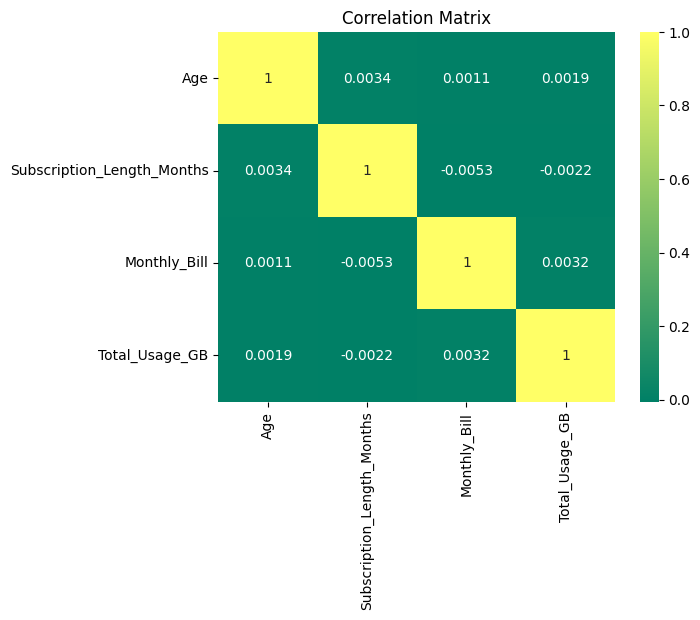

In [26]:
# checking correlation between numeric coumns

# defining numeric columns list
num_cols=['Age','Subscription_Length_Months','Monthly_Bill','Total_Usage_GB']

# plotting a heatmap
sns.heatmap(df[num_cols].corr(),annot=True,cmap='summer');

plt.title('Correlation Matrix');

### Comments
##### 1. Only location seems to have an impact over churn.
##### 2. There is no correlation between any of the numerical features.
##### 3. There is no column that can be dropped in feature engineering as there is no multicollinearity among columns.


# Feature Engineering


In [27]:
def age_category(age):

    ''' Fuction returns a range of age in which the age of customer lies'''
    
    if age in range(18,31):
        return 'Young Adults (18-30)'
    elif age in range(31,46):
        return 'Early Middle-Aged (31-45)'
    elif age in range(46,60):
        return 'Late Middle-Aged (46-60)'
    else:
        return 'Seniors (above 60)'

In [28]:
# adding the age category column

# map function will take each value from the column its called on and will return the value according to the function that is passed as parameter
df['Age_Cat']=df['Age'].map(age_category)

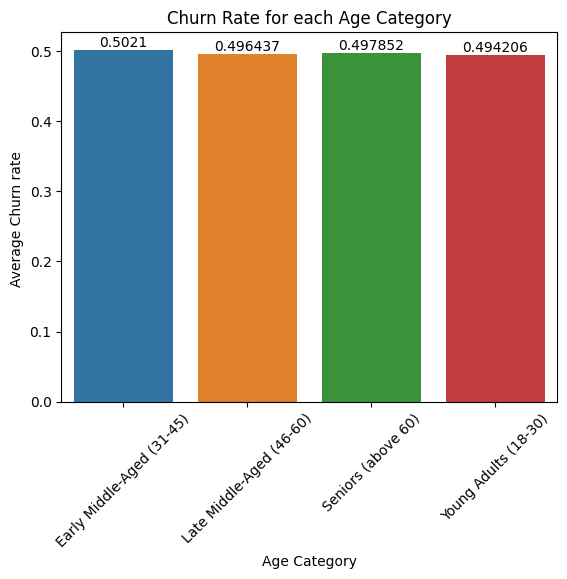

In [29]:
# checking customer churn for different age categories

# number of churned customers for each  age category
age_cat_churn=df.groupby('Age_Cat')['Churn'].mean()

#plotting using bar chart
ax=sns.barplot(x=age_cat_churn.index,y=age_cat_churn);
ax.bar_label(ax.containers[0]);  # writes the count on top of bars

# adding x and y labels
plt.xlabel('Age Category')
plt.ylabel('Average Churn rate ')
plt.xticks(rotation=45);
plt.title('Churn Rate for each Age Category');

### Comments
##### 1. The Churn rate is same for each category.
##### 2. I am using average here because different groups might have different number of customers hence the average. 

In [30]:
# making a new field  cost per Giga byte.
df['Cost_per_Gb']=round(df['Monthly_Bill']/df['Total_Usage_GB'],1)

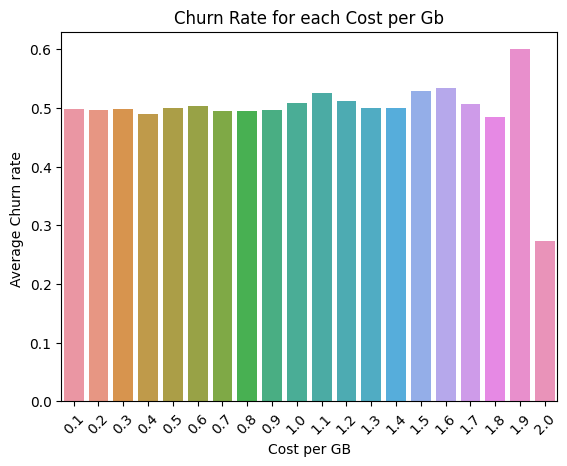

In [31]:
# getting average churn rate for each cost per Gb value.
cost_churn=df.groupby('Cost_per_Gb')["Churn"].mean()

# plotting the above values using bar plot
ax=sns.barplot(x=cost_churn.index,y=cost_churn);

# setting x and y axis labels
plt.xlabel('Cost per GB')
plt.ylabel('Average Churn rate ')
plt.xticks(rotation=45);
plt.title('Churn Rate for each Cost per Gb');

### Comments 
##### 1. The churn rate is almost similar for all the data plans.
##### 2. Cost per GB does not affect the customer churn. 

In [32]:
# Subscription length (months) categories

def subscription_category(months):

    ''' Fuction returns a range of months in which the subscriptin length of customer lies'''
    
    if months in range(1,5):
        return '1-4'
    elif months in range(5,9):
        return '5-8'
    elif months in range(9,13):
        return '9-12'
    elif months in range(13,17):
        return '13-16'
    elif months in range(17,21):
        return '17-20'
    else:
        return '21-24'

In [33]:
# creating new column

# map function will take each value from the column its called on and will return the value according to the function that is passed as paramtere
df['Subscription_Category']=df['Subscription_Length_Months'].map(subscription_category)

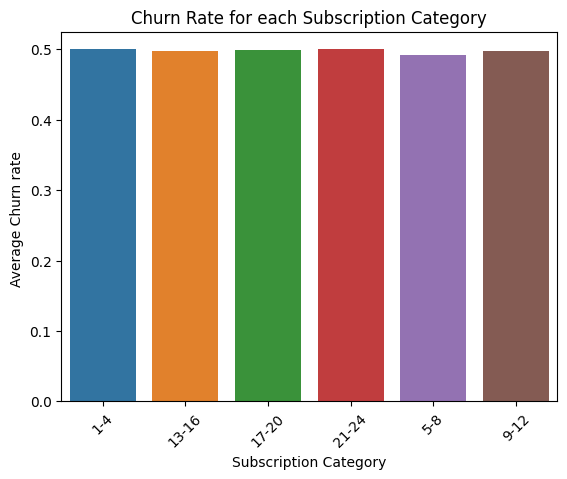

In [34]:
# creates mean of churn for each subscription category
subscription_churn=df.groupby('Subscription_Category')["Churn"].mean()

# plotting using bar plot
ax=sns.barplot(x=subscription_churn.index,y=subscription_churn);

# setting x and y axis labels
plt.xlabel('Subscription Category')
plt.ylabel('Average Churn rate ')
plt.xticks(rotation=45);
plt.title('Churn Rate for each Subscription Category');

### Comments
##### 1. Even subscription Category seems to have no effect on churn rate.

## Insights
#### 1. The data is hughly balanced.
#### 2. There are no observable patterns or trends in the dataset.
#### 3. Even after extensive EDA and feature engineering there are no visible trends.
#### 4. This might hurt our ML model.
#### 5. We need more data. This data seems to be created manually because there is so much balance and randomness at the same time.
#### 6. We might need to seek help from domain experts or collect more meaningful data.


In [35]:
# dropping the newly created columns to keep our model simple as no useful insight can be derived from them
df.drop(['Age_Cat','Cost_per_Gb','Subscription_Category'],axis=1,inplace=True)

In [36]:
# splitting into training and testing data in ratio 7:3

# getting dindependent features
x=df.drop('Churn',axis=1)

# getting target feature
y=df['Churn']

# one hot encoding of categorical features
x=pd.get_dummies(x,drop_first=True)

# splitting into test and train data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Scaling
##### 1. Scaling ensures that all features have equal influence in model training, preventing larger-scaled features from dominating the learning process.
##### 2. Algorithms converge more quickly when features are on a similar scale, saving time and computational resources during training.
##### 3. Scaling can enhance the performance of certain models, helping them make better predictions and cluster data more effectively.
##### 4. I will use MinMaxScaler. The MinMaxScaler is designed to transform data to a specific range, typically between 0 and 1, which is suitable for uniformly distributed data.

In [37]:
# scaling numeric features using Min-Max scaler

# getting columns to be scaled
num_cols=['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']

# defining scaler
scaler=MinMaxScaler()

# scaling train data
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])

# transforming test data acording to scaler fit
X_test[num_cols]=scaler.transform(X_test[num_cols])

# Model Selection
##### 1. I will use k fold cross validation for model selection.
##### 2. I will choose accuracy as my performance metric for now.
##### 3. The average accuracy of all the k runs in cross validation will be compared for each model.


In [38]:
# using 5 fold cross validation method to check mean accuracy of different models on the training data
mean_accu_LR=cross_val_score(LogisticRegression(),X_train,y_train,cv=5,scoring='accuracy').mean()*100

mean_accu_DT=cross_val_score(DecisionTreeClassifier(),X_train,y_train,cv=5,scoring='accuracy').mean()*100

mean_accu_RF=cross_val_score(RandomForestClassifier(),X_train,y_train,cv=5,scoring='accuracy').mean()*100

mean_accu_XG=cross_val_score(xgb.XGBClassifier(),X_train,y_train,cv=5,scoring='accuracy').mean()*100


# Creating a dataframe of all the mean accuracies of the selected algorithms
accu_matrix=pd.DataFrame({'Model':['Logistic Regression','Decision Tree','Random Forest','XG Boost'],
                           'Mean Accuracy %':[mean_accu_LR,mean_accu_DT,mean_accu_RF,mean_accu_XG]})
# printing the dataframe
accu_matrix

,Model,Mean Accuracy %
0,Logistic Regression,49.922857
1,Decision Tree,50.441429
2,Random Forest,49.938571
3,XG Boost,50.124286


### Comments 
##### 1. As expected all the models are performing equally bad.
##### 2. The data is highly balanced with no trends or patterns.
##### 3. The model with 50 % accuracy will do nothing but random guesses.
##### 4. I will still choose Decision Tree classifier.

# Model Training
##### 1. I will again take the raw data and this time use a pipeline.
##### 2. The pipeline consists of two steps.
         step_1: Scaling numeric features and one hot encoding categorical features
         step_2: training the model.

In [39]:
# getting dindependent features
x=df.drop('Churn',axis=1)

# getting target feature
y=df['Churn']

# splitting into test and train data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [40]:
# step 1 scales the numeric columns and one hot encode the categorical columns
step_1=  ColumnTransformer(transformers=[('scale',scaler,[0,3,4,5]),
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[1,2])
])

# step 2 initializes the classifier
step_2= DecisionTreeClassifier()

# pipeline performs step 1 on data first then step 2
pipe = Pipeline([
    ('step_1',step_1),
    ('step_2',step_2)
])

# using the pipe on training data
pipe.fit(X_train,y_train)

# making predictions on test data
y_pred = pipe.predict(X_test)

# printing classification report
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50     15152
           1       0.49      0.50      0.50     14848

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



# Hyper Parameter Tuning

In [41]:
# Define a grid of hyperparameters to search , the 'step_2__' before the parameters indicates our classifier (decision tree) 
param_grid = {
    'step_2__criterion': ['gini', 'entropy'],
    'step_2__max_depth': [None, 10, 20, 30],
    'step_2__min_samples_split': [2, 5, 10],
    'step_2__min_samples_leaf': [1, 2, 4]
}
# Create a GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator (model) from the grid search
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate the best model
print(classification_report(y_test, y_pred))


Best Hyperparameters: {'step_2__criterion': 'entropy', 'step_2__max_depth': 30, 'step_2__min_samples_leaf': 4, 'step_2__min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     15152
           1       0.49      0.47      0.48     14848

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



### Comments
##### 1. I have used decision Tree.
##### 2. The model's performance is below satisfactory.
##### 3. It has to do with the randomness of data and the way all the features are balanced.
##### 4. I used Grid Search 5 fold cross validation to estimate the best hyper parameters but the model performance with those parameters is still the same.
##### 5. I will stick to the model with default parameters.

# Model Deployment
##### 1. I will now export my trained model using pickle.
##### 2. I have created a simple streamlit webapp that takes input and prdict churn based on our model.

In [42]:
# exporting the model and dataframe for web app
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))

# Conclusion

### 1. Data Balance and Uniformity
##### The dataset was found to be highly balanced and uniformly distributed across all features, indicating an equal representation of target classes and consistent feature scales.

### 2. Inconclusive EDA
##### Exploratory Data Analysis (EDA) did not yield significant insights or reveal any discernible trends or patterns in the data, suggesting that the data might be inherently noisy or challenging to model.

### 3. Feature Engineering Efforts
##### Despite attempts at feature engineering, no meaningful patterns or relationships were discovered in the data. This suggests that the inherent complexity of the problem may require more sophisticated feature engineering techniques.

### 4. Model Performance 
##### Initial models, including a Decision Tree Classifier, achieved only modest accuracy (around 50%), indicating that the dataset might be inherently difficult to predict based on the given features.

### 5. Hyperparameter Tuning 
##### Hyperparameter tuning was performed, but it did not substantially improve the model's performance, suggesting that the limitations might be related to the data itself.

### 6. Streamlit Web App 
##### To make the model accessible and user-friendly, a Streamlit web app was created, allowing users to input data and receive predictions based on the trained model.
ed model.


# Future Work

### 1. Collect More Data
##### In cases where data is limited or inconclusive, collecting more data, especially diverse or domain-specific data, could potentially improve model performance.

### 2. Advanced Modeling 
##### Explore more complex models or ensemble methods to capture intricate patterns that simpler models might miss.

### 3. Domain Expertise
##### Collaborate with domain experts who may provide valuable insights or domain-specific knowledge to enhance the analysis